In [427]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lumapi

In [428]:
mode = lumapi.MODE()

In [429]:
T = 298.15
W_bragg = 1565.66e-9

r_film = 4.8e-6
r_cladding = 62e-6

n_low = 1.4725
n_high = 1.4728
n_cladding = 1.466

length = 2e-6

## Define geometry

In [430]:
mode.switchtolayout()
mode.deleteall()

mode.addring()
mode.set('alpha',0.4)
mode.set("name", "cladding")
mode.set("first axis", "y")
mode.set('rotation 1', 90)
mode.set("z span", length)
mode.set('outer radius', r_cladding)
mode.set('inner radius', r_film)
mode.set('index', n_cladding)

mode.addcircle()
mode.set('alpha',0.6)
mode.set("name", "low")
mode.set("first axis", "y")
mode.set('rotation 1', 90)
mode.set("z span", length/2)
mode.set('x',-length/4)
mode.set('radius', r_film)
mode.set('index', n_low)

mode.addcircle()
mode.set('alpha',1)
mode.set("name", "high")
mode.set("first axis", "y")
mode.set('rotation 1', 90)
mode.set("z span", length/2)
mode.set('x',length/4)
mode.set('radius', r_film)
mode.set('index', n_high)

## Define FDE solvers

In [431]:
mode.select('FDE')
mode.delete()

mode.addfde()
mode.set("simulation temperature", T)
mode.set("solver type", "2D X normal")
mode.set("y min bc", "Anti-Symmetric")
mode.set("y max bc", "Metal")
mode.set("z min bc", "Symmetric")
mode.set("y max bc", "Metal")
mode.set('z', 0)
mode.set('y', 0)
mode.set('y span', 5*r_film)
mode.set('z span', 5*r_film)

## Define mesh

In [432]:
mode.select('mesh')
mode.delete()

mode.addmesh()
mode.set("x", 0)
mode.set('z', 0)
mode.set('y', 0)
mode.set('x span', length)
mode.set('y span', 2*r_film)
mode.set('z span', 2*r_film)
mode.set("set mesh multiplier", 1)
mode.set('x mesh multiplier', 0)
mode.set('y mesh multiplier', 5)
mode.set('z mesh multiplier', 5)

## Run

In [433]:
mode.save("Bragg")

In [434]:
mode.switchtolayout()
mode.select("FDE")
mode.set("x", length/4)
mode.findmodes()

group_index_high = np.abs(mode.getresult("FDE::data::mode1", "ng")[0][0])
neff_high = np.abs(mode.getresult("FDE::data::mode1", "neff")[0][0])
print("high index - ng = ", group_index_high," neff = ", neff_high)


mode.switchtolayout()
mode.select("FDE")
mode.set("x", -length/4)
mode.findmodes()

group_index_low = np.abs(mode.getresult("FDE::data::mode1", "ng")[0][0])
neff_low = np.abs(mode.getresult("FDE::data::mode1", "neff")[0][0])
print("low index - ng = ", group_index_low," neff = ", neff_low)


high index - ng =  1.4737611944126683  neff =  1.4701252192434862
low index - ng =  1.473408371293647  neff =  1.4698639451590636


## Bragg periodicity ($\Lambda$)

$$
\Lambda = \frac{\lambda_{Bragg}}{2n_{eff}}
$$

Where,

$$
n_{eff} = \frac{{n_{eff}}_1+{n_{eff}}_2}{2}
$$

In [435]:
Lambda = W_bragg/((neff_low+neff_high))
print("Lambda = ", Lambda*1e6, " um")

Lambda =  0.5325393776810622  um


## Define EME solver

In [436]:
Temperatura = [298,373,573,773,973,1173,1273]

eta1 = 5.327e-6
eta2 = 4.773e-9

nb = 1000
wvg = np.linspace(1562e-9, 1584e-9, nb)


In [437]:
mode.switchtolayout()
mode.select('EME')
mode.delete()

mode.addeme()
mode.set("simulation temperature", Temperatura[0])
mode.set("solver type", "3D: X prop")
mode.set("energy conservation", "conserve energy")
mode.set("z min bc", "Symmetric")
mode.set("x", 0)
mode.set('z', 0)
mode.set('y', 0)

mode.set("x min", -Lambda/2)
mode.set('y span', 10*r_film)
mode.set('z span', 10*r_film)

mode.set("number of cell groups", 2)
mode.set("number of modes for all cell groups", 1)
mode.set("group spans" , np.array([Lambda/2, Lambda/2]))

mode.set("number of periodic groups", 1)
mode.set("start cell group", 1)
mode.set("end cell group", 2)
mode.set("periods", 10000)

mode.set("pml sigma", 30)

In [438]:
Transmissao = []
S11_modulo = []
S11_fase = []
S21_modulo = []
S21_fase = []

for i in range(len(Temperatura)):
    mode.switchtolayout()

    T = Temperatura[i]

    mode.select('EME')
    mode.set("simulation temperature", T)
    mode.select('cladding')
    mode.set('index', n_cladding*(1+eta1*(T-273)+eta2*(T-273)**2))
    mode.select('low')
    mode.set('index', n_low*(1+eta1*(T-273)+eta2*(T-273)**2))
    mode.select('high')
    mode.set('index', n_high*(1+eta1*(T-273)+eta2*(T-273)**2))
    mode.run()

    mode.setemeanalysis("wavelength sweep", 1)
    mode.setemeanalysis("start wavelength",wvg[0])
    mode.setemeanalysis("stop wavelength",wvg[-1])
    mode.setemeanalysis("number of wavelength points", nb)
    mode.emesweep("wavelength sweep")

    Resultado = mode.getemesweep("S_wavelength_sweep")
    
    Transmissao.append(np.abs(Resultado['s11'])**2)
    S11_modulo.append(np.abs(Resultado['s11']))
    S11_fase.append(np.angle(Resultado['s11']))
    S21_modulo.append(np.abs(Resultado['s21']))
    S21_fase.append(np.angle(Resultado['s21']))
    


In [439]:
# print((np.abs(Resultado['s11'])**2))

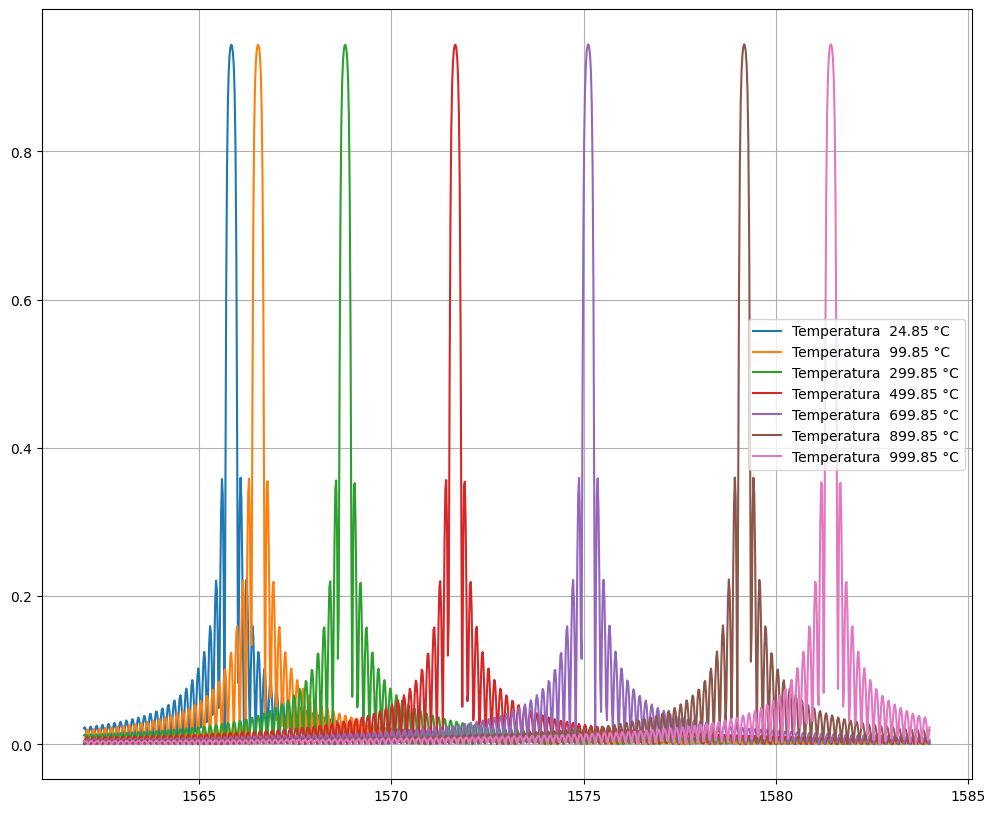

In [444]:
plt.figure(figsize=(12,10))
for i in range(len(Temperatura)):
    plt.plot(wvg*1e9,S11_modulo[i], label = f'Temperatura {Temperatura[i] - 273.15 : .2f} °C')

plt.legend()
plt.grid()
plt.show()


## S-parameters

In [441]:
S11 = np.zeros((len(wvg), 2*len(Temperatura)))
S21 = np.zeros((len(wvg), 2*len(Temperatura)))

for i in range(0,len(Temperatura),1):
    S11[:,2*i] = S11_modulo[i]
    S11[:,2*i+1] = S11_fase[i]

    S21[:,2*i] = S21_modulo[i]
    S21[:,2*i+1] = S21_fase[i]

    

In [442]:
filename = "fbg_s_param_T.dat"

# Parâmetros
c = 3e8
coln = 2*len(Temperatura) + 1
TM = np.transpose(Temperatura)
numMode = 1  # 1 modo
numPort = 2  # 2 portas
modeLabel = ["TE"]  # lista com rótulos de modos

with open(filename, "w") as f:
    for kk in range(numMode):
        for mm in range(numPort):  # porta de saída
            for nn in range(numPort):  # porta de entrada

                mystr = (
                    f"(\"port {mm+1}\",\"{modeLabel[kk]}\",{kk+1},"
                    f"\"port {nn+1}\",1,\"modulation\")\n"
                    f"(1,{len(Temperatura)})\n"
                )
                f.write(mystr)

                f.write(" ".join(f"{x:.2f}" for x in TM) + "\n")

                f.write(f"({len(wvg)},{coln})\n")


                # Seleciona o conjunto de dados correto
                if mm == 0 and nn == 0 and kk == 0:  # S11
                    mymtrx = np.column_stack((c * 1e9 / (wvg*1e9), S11))
                elif mm == 1 and nn == 0 and kk == 0:  # S21
                    mymtrx = np.column_stack((c * 1e9 / (wvg*1e9), S21))
                else:
                    mymtrx = np.column_stack((c * 1e9 / (wvg*1e9), S11))

                # Escreve os dados numéricos
                np.savetxt(f, mymtrx, fmt="%.6e", delimiter="\t")
 